# DeepSurv

## Init

https://nbviewer.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb
https://nbviewer.org/github/havakv/pycox/blob/master/examples/cox-ph.ipynb

In [ ]:
# ! pip install sklearn-pandas

In [73]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [74]:
DATA_PATH = '../datasets/preprocessed'

# Set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

In [75]:
plus_clinical_data = False

## Data

In [86]:
dataset = pd.read_csv(os.path.join(DATA_PATH, 'clinical_miRNA_normalized_log.csv'))
#dataset = pd.read_csv(os.path.join(DATA_PATH, 'clinical_mRNA_normalized_log.csv'))

unique, count = np.unique(dataset['age_at_initial_pathologic_diagnosis'], return_counts=True)
to_drop = [unique[u] for u in range(len(unique)) if count[u] < 5]

dataset=dataset[~dataset['age_at_initial_pathologic_diagnosis'].isin(to_drop)]

In [87]:
dataset = dataset.rename(columns={'Death': 'event', 'days_to_last_followup': 'duration'})
dataset.drop(columns=['days_to_death'], inplace=True)

if not plus_clinical_data:
    # remove clinical data columns
    clinical_cols = [col for col in dataset.columns if not col.startswith('hsa') and col != 'duration' and col != 'event']
    dataset.drop(columns=clinical_cols, inplace=True)

# X = X.loc[:, X.var() != 0]  # remove columns with zero-variance

In [82]:
df_train = dataset.copy()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [42]:
df_train.head()

,duration,event,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,...,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
1,1309.0,0,13.533484,13.517790,13.531608,13.763557,12.145069,9.214196,9.960600,13.076093,...,-9.965784,1.501221,-9.965784,0.331933,-0.082723,-9.965784,3.945590,6.290807,9.617923,14.042346
2,0.0,0,12.950991,12.976972,12.959169,13.347458,10.917947,8.413247,9.008580,11.445665,...,-9.965784,2.731636,-9.965784,-9.965784,0.562472,-9.965784,3.561616,4.605948,10.146458,14.821642
3,212.0,0,13.798841,13.806151,13.812977,13.747714,10.033127,8.367789,11.908229,12.663077,...,-9.965784,1.946316,-9.965784,-0.714655,1.158093,-9.965784,5.213753,6.909914,8.311808,15.682633
4,2763.0,1,12.234379,12.224318,12.263043,13.262601,10.722234,9.383339,12.021623,10.959604,...,-9.965784,2.049514,-9.965784,-9.965784,2.175016,-9.965784,6.065489,6.460115,8.909409,17.328067
5,11.0,0,12.982141,12.971191,12.967270,14.277522,11.281450,8.897061,9.939001,11.135322,...,-9.965784,2.492173,-9.965784,-0.506033,2.299564,-9.965784,6.164362,7.584681,8.514288,14.540829


## Feature transforms

Note that PyTorch require variables of type 'float32'.

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

scaler = StandardScaler()

cols_leave = [col for col in dataset.columns if col.startswith('pathologic')]
cols_standardize = [col for col in dataset.columns if col not in cols_leave + ['duration', 'event']]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [44]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

Applichiamo lo scaler solo alle colonne miRNA?

In [45]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

## Neural net

a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. Here, we just use the torchtuples.practical.MLPVanilla net to do this.

Note that we set out_features to 1, and that we have not output_bias.

In [48]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

a more complex net with more layers and different activations could be defined as follows

In [ ]:
class DeepSurvNet_5(tt.torch.nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_features, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(128, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),

            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),

            torch.nn.Linear(16, 1)  # output: log hazard
        )

    def forward(self, x):
        return self.net(x)
                        
in_features = x_train.shape[1]
net_5 = DeepSurvNet_5(in_features)

## Training the model

We use the Adam optimizer, but instead of choosing a learning rate, we will use the scheme proposed by Smith 2017 (https://arxiv.org/pdf/1506.01186) to find a suitable learning rate with model.lr_finder. See this post for an explanation.

In [49]:
model = CoxPH(net, tt.optim.Adam)

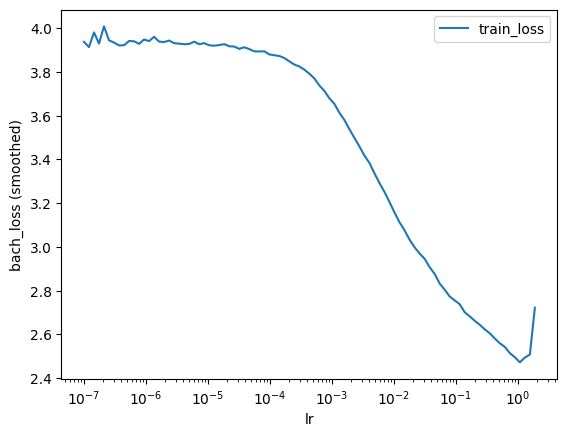

In [50]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [51]:
lrfinder.get_best_lr()

np.float64(0.10722672220103299)

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [52]:
model.optimizer.set_lr(0.01)

We include the EarlyStopping callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [53]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [54]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 3.9653,	val_loss: 2.9242
1:	[0s / 0s],		train_loss: 2.8211,	val_loss: 2.8485
2:	[0s / 0s],		train_loss: 2.4330,	val_loss: 2.8434
3:	[0s / 0s],		train_loss: 2.0977,	val_loss: 2.8503
4:	[0s / 0s],		train_loss: 1.9074,	val_loss: 2.8846
5:	[0s / 0s],		train_loss: 1.6632,	val_loss: 2.9398
6:	[0s / 0s],		train_loss: 1.4604,	val_loss: 3.0448
7:	[0s / 0s],		train_loss: 1.6355,	val_loss: 3.1628
8:	[0s / 0s],		train_loss: 1.5222,	val_loss: 3.2427
9:	[0s / 0s],		train_loss: 1.7112,	val_loss: 3.2910
10:	[0s / 0s],		train_loss: 1.6108,	val_loss: 3.2639
11:	[0s / 0s],		train_loss: 1.1781,	val_loss: 3.2658
12:	[0s / 0s],		train_loss: 1.3315,	val_loss: 3.3132
CPU times: total: 375 ms
Wall time: 262 ms


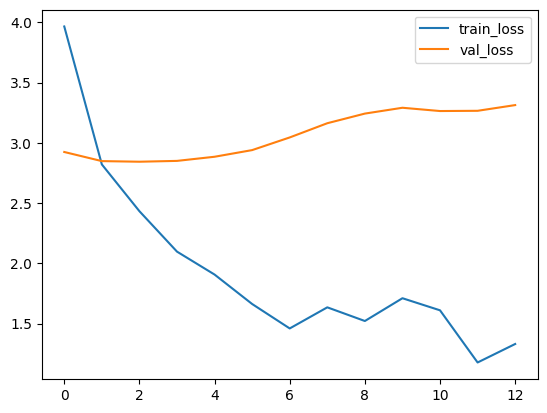

In [55]:
_ = log.plot()

In [56]:
model.partial_log_likelihood(*val).mean()

np.float32(-2.8434372)

## Prediction

However, as CoxPH is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

In [57]:
_ = model.compute_baseline_hazards()

surv = model.predict_surv_df(x_test)

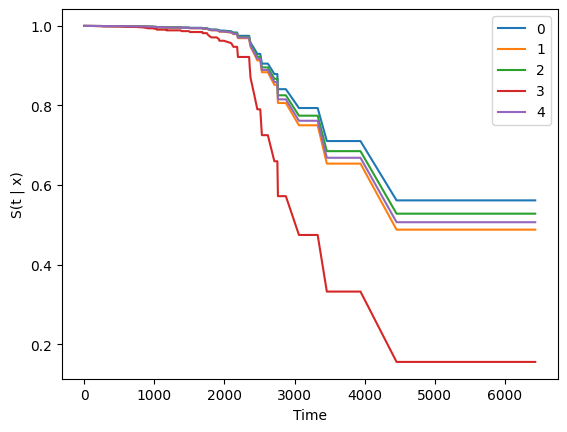

In [58]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

We can use the EvalSurv class for evaluation the concordance, brier score and binomial log-likelihood. Setting censor_surv='km' means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [60]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [61]:
ev.concordance_td()

0.6143867924528302

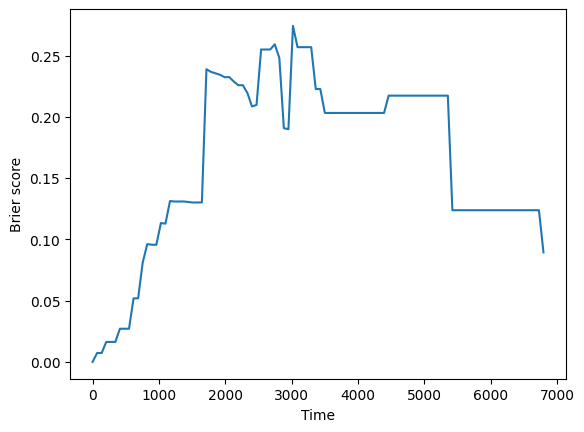

In [66]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Negative binomial log-likelihood

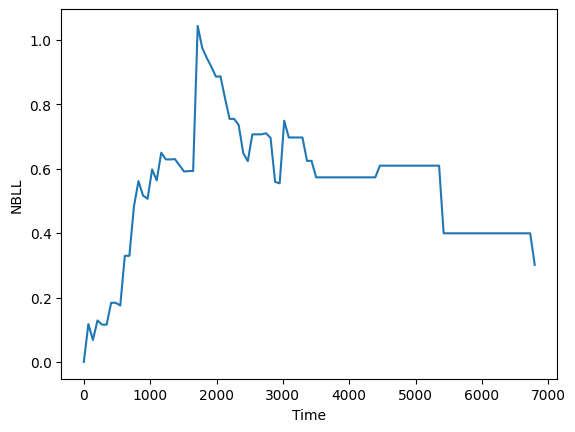

In [67]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score Graf et al. 1999. In practice this is done by numerical integration over a defined time_grid.

In [63]:
ev.integrated_brier_score(time_grid)

np.float64(0.16594631406176094)

In [64]:
ev.integrated_nbll(time_grid)

np.float64(0.5467750645218336)